In [11]:
# Reference to ../src
import os
import sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import csv
import os

from dataset.MicroscopyTrainDataLoader import MicroscopyTrainDataLoader
from experiments.microscopy.microscopy import experiment, get_model
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from sklearn.metrics import classification_report

import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

import torchvision

In [12]:
OUTPUT_PATH = '../labels/microscopy.csv'
JSON_INPUT_PATH = "../src/experiments/microscopy/shallow-resnet101.json"
JSON_OUTPUT_PATH = "../src/experiments/microscopy/out_shallow_resnet101.json"

In [13]:
def load_model(model_id, model_dict):
    model_name, experiment_name = model_id.split('.')
    print(model_name)
    model = experiment(experiment_name, model_name, num_classes=4, pretrained=True)
    
    checkpoint = torch.load('../outputs/{0}/checkpoint.pt'.format(model_dict[model_id]))
    model.load_state_dict(checkpoint)
    
    return model

def load_shallow_model(model_id, model_dict):
    model_name, experiment_name = model_id.split('.')
    model = get_model(model_name, "shallow", 4, layers=model_dict[model_id]['layers'], pretrained=True)
    
    checkpoint = torch.load('../outputs/{0}/checkpoint.pt'.format(model_dict[model_id]['id']))
    model.load_state_dict(checkpoint)
    
    return model

def test(model_id, models, is_shallow=False):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss()
    
    if not is_shallow:
        model = load_model(model_id, models)
    else:
        model = load_shallow_model(model_id, models)
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    model = model.to(device)
    
    model.eval()
    
    kwargs = {'num_workers': 16, 'pin_memory': True} if torch.cuda.is_available() else {}
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, **kwargs)
    
    test_loss, n_iter = 0, 0
    total, correct = 0, 0
    
    y_true = []
    y_pred = []
    img_names = []
    
    for images, labels, img_path in test_loader:         
        y_true += labels
        img_names += img_path

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred += predicted.cpu()

        loss = criterion(outputs, labels)

        total += labels.size(0)
        correct += torch.sum(predicted == labels.data)
        test_loss += loss.item()
        n_iter += 1

    acc = 100 * torch.true_divide(correct, total)
    average_loss = test_loss / n_iter
    
    target_names = test_dataset.codec.classes_
    print(classification_report(y_true, y_pred, target_names=target_names, digits=4))
    
    return acc.cpu(), average_loss, y_true, y_pred, img_names, trainable_params, total_params

def get_results(a, b):
    c = []
    for i in range(len(a)):
        c.append(1 if a[i] == b[i] else 0)
    return c

## Use a json file to map the runs to compare to the wandb_id

In [14]:
import json

with open(JSON_INPUT_PATH) as json_file:
    models = json.load(json_file)

models

{'resnet101.layer4-2': {'id': 'helpful-snowball-485', 'layers': [3, 4, 23, 3]},
 'resnet101.layer4-1': {'id': 'daily-river-484', 'layers': [3, 4, 23, 2]},
 'resnet101.layer4-0': {'id': 'sweet-disco-483', 'layers': [3, 4, 23, 1]},
 'resnet101.layer3-22': {'id': 'balmy-pyramid-482', 'layers': [3, 4, 23, 0]},
 'resnet101.layer3-21': {'id': 'earthy-blaze-481', 'layers': [3, 4, 22, 0]},
 'resnet101.layer3-20': {'id': 'radiant-surf-480', 'layers': [3, 4, 21, 0]},
 'resnet101.layer3-19': {'id': 'dazzling-plasma-479', 'layers': [3, 4, 20, 0]},
 'resnet101.layer3-18': {'id': 'snowy-voice-478', 'layers': [3, 4, 19, 0]},
 'resnet101.layer3-17': {'id': 'fragrant-rain-476', 'layers': [3, 4, 18, 0]},
 'resnet101.layer3-16': {'id': 'distinctive-jazz-475',
  'layers': [3, 4, 17, 0]},
 'resnet101.layer3-15': {'id': 'happy-dream-473', 'layers': [3, 4, 16, 0]},
 'resnet101.layer3-14': {'id': 'distinctive-salad-471',
  'layers': [3, 4, 15, 0]},
 'resnet101.layer3-13': {'id': 'desert-haze-470', 'layers': [

In [15]:
# get test dataset
loader = MicroscopyTrainDataLoader(OUTPUT_PATH)
test_dataset = loader.get_test_dataset()

In [16]:
results = {}
accs = {}
ys = {}
is_shallow=True

for key in models:
    print(key)
    acc, loss, y_true, y_pred, target_names, trainable_params, total_params = test(key, models, is_shallow=is_shallow)
    correct = get_results(y_true, y_pred)
    results[key] = correct
    accs[key] = acc
    ys[key] = {
        'y_true': [y.item() for y in y_true],
        'y_pred': [y.item() for y in y_pred],
        'correct': correct,
        'acc': acc.item(),
        'images': target_names,
        'trainable_params': trainable_params,
        'total_params': total_params
    }
results['images'] = target_names

resnet101.layer4-2
              precision    recall  f1-score   support

        DMEL     0.6349    0.4545    0.5298        88
        DMFL     0.9178    0.9437    0.9306       284
        DMLI     0.9204    0.9704    0.9447       405
        DMTR     0.8022    0.7604    0.7807        96

    accuracy                         0.8866       873
   macro avg     0.8188    0.7822    0.7965       873
weighted avg     0.8778    0.8866    0.8803       873

resnet101.layer4-1
              precision    recall  f1-score   support

        DMEL     0.5556    0.5114    0.5325        88
        DMFL     0.9147    0.9437    0.9289       284
        DMLI     0.9353    0.9630    0.9489       405
        DMTR     0.7927    0.6771    0.7303        96

    accuracy                         0.8797       873
   macro avg     0.7995    0.7738    0.7852       873
weighted avg     0.8746    0.8797    0.8764       873

resnet101.layer4-0
              precision    recall  f1-score   support

        DMEL     0

              precision    recall  f1-score   support

        DMEL     0.6515    0.4886    0.5584        88
        DMFL     0.9399    0.9366    0.9383       284
        DMLI     0.9327    0.9580    0.9452       405
        DMTR     0.7130    0.8021    0.7549        96

    accuracy                         0.8866       873
   macro avg     0.8093    0.7963    0.7992       873
weighted avg     0.8825    0.8866    0.8830       873

resnet101.layer3-6
              precision    recall  f1-score   support

        DMEL     0.6026    0.5341    0.5663        88
        DMFL     0.9493    0.9225    0.9357       284
        DMLI     0.9200    0.9654    0.9422       405
        DMTR     0.7021    0.6875    0.6947        96

    accuracy                         0.8774       873
   macro avg     0.7935    0.7774    0.7847       873
weighted avg     0.8736    0.8774    0.8750       873

resnet101.layer3-5
              precision    recall  f1-score   support

        DMEL     0.6133    0.5227    

In [17]:
with open(JSON_OUTPUT_PATH, 'w') as fp:
    json.dump(ys, fp)

In [39]:
df = pd.DataFrame(data=results)
df.head()

,resnet34.layer4-2,resnet34.layer4-1,resnet34.layer4-0,resnet34.layer3-5,resnet34.layer3-4,resnet34.layer3-3,resnet34.layer3-2,resnet34.layer3-1,resnet34.layer3-0,resnet34.layer2-3,resnet34.layer2-2,resnet34.layer2-1,resnet34.layer2-0,resnet34.layer1-2,resnet34.layer1-1,resnet34.layer1-0,images
0,1,1,1,1,1,1,1,1,0,1,0,1,0,1,1,0,1471-2180-11-111-1-4.jpg
1,0,0,0,1,0,1,0,0,1,0,0,1,1,1,1,1,1471-2121-11-29-4-3.jpg
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1471-2180-11-111-1-3.jpg
3,0,0,1,1,0,1,0,0,1,0,0,0,0,1,1,1,1471-2121-11-29-4-4.jpg
4,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1471-2202-9-81-12-12.jpg


<AxesSubplot:>

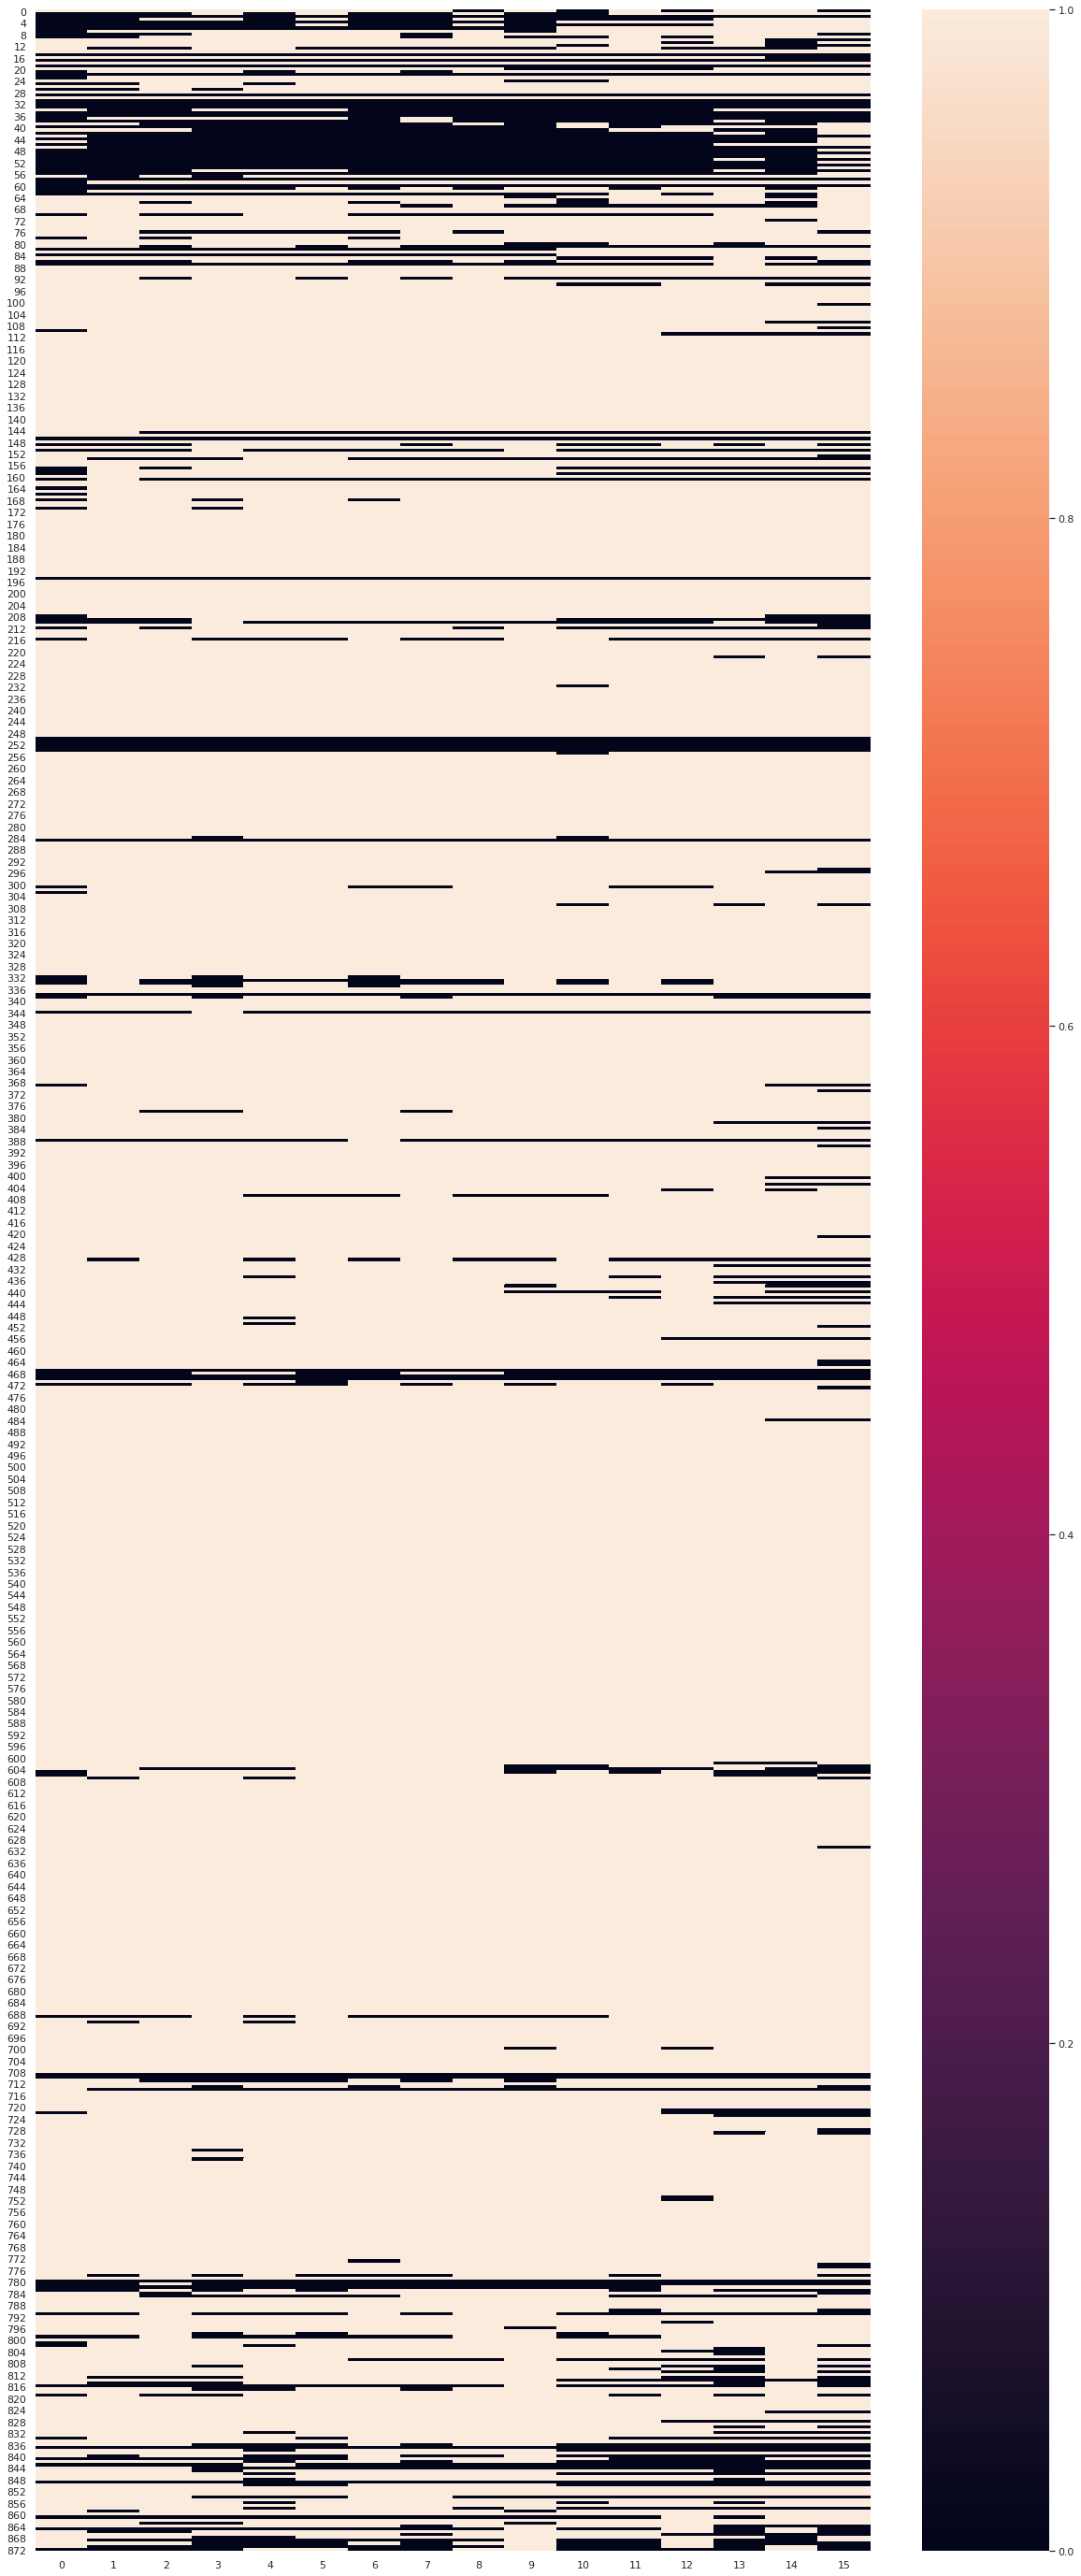

In [40]:
a4_dims = (20, 50)

fig, ax = plt.subplots(figsize=a4_dims)
uniform_data = np.random.rand(873, len(models))

data = df[models].to_numpy()
sns.heatmap(ax=ax, data=data)

## Accuracy over different models

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

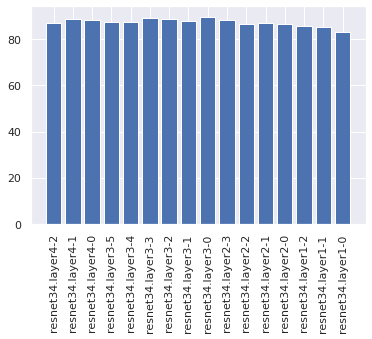

In [41]:
x = accs.keys()
y = [accs[i] for i in accs.keys()]
plt.bar(x,y)
plt.xticks(rotation=90)

In [12]:
from sklearn.metrics import confusion_matrix
matrices = {}
for m in models:
    matrices[m] = confusion_matrix(ys[m]['y_true'], ys[m]['y_pred'])
test_dataset.codec.classes_.tolist()

['DMEL', 'DMFL', 'DMLI', 'DMTR']

In [13]:
import seaborn as sns

sns.heatmap(matrices['resnet50.layer4-2.loss'], annot=True,
                xticklabels=test_dataset.codec.classes_.tolist(),
                yticklabels=test_dataset.codec.classes_.tolist())

KeyError: 'resnet50.layer4-2.loss'

In [ ]:
sns.heatmap(matrices['resnet50.layer4-1.loss'], annot=True,
                xticklabels=test_dataset.codec.classes_.tolist(),
                yticklabels=test_dataset.codec.classes_.tolist())

In [ ]:
sns.heatmap(matrices['resnet50.layer4-0.loss'], annot=True,
                xticklabels=test_dataset.codec.classes_.tolist(),
                yticklabels=test_dataset.codec.classes_.tolist())

Most of the errors appear on the classes with less number of examples. Try weighted approach for sampling and check normalization appraoches

In [ ]:
test_labels = test_dataset.codec.transform(test_dataset.df['MODALITY'])

In [ ]:
df.head()

In [15]:
columns = models
df['num_correct'] = df[columns].sum(axis=1)
df.head()

,resnet152.fc,resnet152.layer4-2,resnet152.layer4-1,resnet152.layer4-0,resnet152.layer3-35,resnet152.layer3-34,resnet152.layer3-33,resnet152.layer3-32,resnet152.layer3-31,resnet152.layer3-30,...,resnet152.layer2-3,resnet152.layer2-2,resnet152.layer2-1,resnet152.layer2-0,resnet152.layer1-2,resnet152.layer1-1,resnet152.layer1-0,resnet152.whole,images,num_correct
0,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,1,1471-2180-11-111-1-4.jpg,42
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1471-2121-11-29-4-3.jpg,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1471-2180-11-111-1-3.jpg,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1471-2121-11-29-4-4.jpg,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1471-2202-9-81-12-12.jpg,0


In [16]:
incorrect_images = df[df['num_correct'] == 0]
incorrect_images.head()

,resnet152.fc,resnet152.layer4-2,resnet152.layer4-1,resnet152.layer4-0,resnet152.layer3-35,resnet152.layer3-34,resnet152.layer3-33,resnet152.layer3-32,resnet152.layer3-31,resnet152.layer3-30,...,resnet152.layer2-3,resnet152.layer2-2,resnet152.layer2-1,resnet152.layer2-0,resnet152.layer1-2,resnet152.layer1-1,resnet152.layer1-0,resnet152.whole,images,num_correct
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1471-2121-11-29-4-3.jpg,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1471-2121-11-29-4-4.jpg,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1471-2202-9-81-12-12.jpg,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1471-2121-11-29-4-5.jpg,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1471-2202-9-81-12-8.jpg,0


In [17]:
incorrect_image_names = incorrect_images['images'].tolist()
incorrect_image_idx = incorrect_images.index.values.tolist()
incorrect_image_idx[:20]

[1, 3, 4, 5, 8, 15, 17, 19, 22, 29, 31, 32, 33, 36, 38, 40, 42, 44, 46, 48]

In [19]:
correct_labels = test_dataset.codec.inverse_transform(ys['resnet50.layer4-2']['y_true'])
correct_labels[0:10]

KeyError: 'resnet50.layer4-2'

In [ ]:
incorrect_image_paths = ['/mnt/test/{0}/{1}'.format(correct_labels[incorrect_image_idx[i]], incorrect_image_names[i]) for i in range(len(incorrect_images))]

In [ ]:
incorrect_image_paths[0]

In [ ]:
7 // total_images

In [14]:
from skimage import io

total_images = len(incorrect_images)
images_per_row = 6
total_rows = total_images // images_per_row + 1

y_pred_whole = np.array(ys['resnet50.whole.loss']['y_pred'])[incorrect_image_idx]
y_pred_whole = test_dataset.codec.inverse_transform(y_pred_whole)

f, axarr = plt.subplots(total_rows,images_per_row, figsize=(15,30))
for i in range(total_images):
    x = io.imread(incorrect_image_paths[i])
    col = i % images_per_row
    row = i // images_per_row
    axarr[row, col].imshow(x)
    axarr[row, col].title.set_text(str(i) + ": " + incorrect_image_paths[i][10:15] + y_pred_whole[i])
    axarr[row, col].axis('off')

NameError: name 'incorrect_images' is not defined

In [ ]:
len(incorrect_images)

In [ ]:
len(incorrect_image_paths)

In [ ]:
# y_pred_whole = np.array(ys['resnet50.whole.loss']['y_pred'])[incorrect_image_idx]
# y_pred_whole = test_dataset.codec.inverse_transform(y_pred_whole)
# y_pred_whole

In [ ]:
# accs

In [ ]:
# %matplotlib inline
# y_acc = [accs[x].item() for x in accs.keys()]
# x_acc = [x for x in accs.keys()]
# plt.plot(x_acc, y_acc)
# plt.xticks(rotation=90)

In [ ]:
# m = experiment('whole', 'resnet101', num_classes=4, pretrained=True)

In [ ]:
# len(m.layer4)

In [ ]:
# new_classifier = nn.Sequential(*list(m.children())[:-1])

In [ ]:
# print(new_classifier)

In [ ]:
# img = torch.Tensor(1, 3, 224, 224).normal_() 
# outputs = new_classifier(img)
# outputs = outputs.view(-1)

In [ ]:
# outputs

In [ ]:
# incorrect_image_paths[48]

In [ ]:
# ys['resnet50.layer4-2.loss']['y_true']